In [164]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
import csv
from sentence_transformers import SentenceTransformer
import faiss, numpy as np
import math
import mlflow
import os
import json

In [152]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Set default experiment
mlflow.set_experiment("news_recommender_experiment")

2025/10/14 15:51:57 INFO mlflow.tracking.fluent: Experiment with name 'news_recommender_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/483396273814098465', creation_time=1760437317238, experiment_id='483396273814098465', last_update_time=1760437317238, lifecycle_stage='active', name='news_recommender_experiment', tags={}>

In [2]:
def utc_to_unix(utc_str):
    """
    Convert UTC string (ISO format) to Unix timestamp (seconds since epoch).
    Example: '2023-07-11T13:40:05.511Z' -> 1689082805
    """
    try:
        dt = datetime.fromisoformat(utc_str.replace("Z", "+00:00"))  # parse ISO string
        return int(dt.timestamp())
    except:
        return None

def unix_to_utc(unix_ts):
    """
    Convert Unix timestamp (int or float) to UTC datetime string (ISO format).
    Example: 1689082805 -> '2023-07-11T13:40:05+00:00'
    """
    try:
        unix_secs = unix_ts//1000
        dt = datetime.fromtimestamp(unix_secs, tz=timezone.utc)
        return dt.isoformat()
    except:
        return None

# Users Data

In [3]:
user_df = pd.read_csv('../test_data/test_data/devices/devices.csv')

In [ ]:
# Convert datetimes
user_df['created_datetime'] = pd.to_datetime(user_df['created_datetime'], errors='coerce')
user_df['last_active_at'] = pd.to_datetime(user_df['last_active_at'], errors='coerce')

# --------------------------
# Create Subplots
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("User Table EDA Dashboard", fontsize=18, fontweight="bold")

# 1. Platform distribution
sns.countplot(y="platform", data=user_df, 
              order=user_df['platform'].value_counts().index, ax=axes[0,0])
axes[0,0].set_title("User Distribution by Platform")

# 2. OS Version (Top 10)
user_df['os_version'].value_counts().head(10).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title("Top 10 OS Versions")
axes[0,1].set_xlabel("OS Version")
axes[0,1].set_ylabel("Users")

# 3. Device Model (Top 10)
user_df['model'].value_counts().head(10).plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title("Top 10 Device Models")
axes[0,2].set_xlabel("Device Model")
axes[0,2].set_ylabel("Users")

# 4. Language Preferences (Top 10)
sns.countplot(y="language_selected", data=user_df,
              order=user_df['language_selected'].value_counts().index[:10],
              ax=axes[1,0])
axes[1,0].set_title("Top 10 Languages")
axes[1,0].set_xlabel("Count")
axes[1,0].set_ylabel("Language")

# 5. Districts (Top 10)
user_df['lastknownsubadminarea'].value_counts().head(10).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title("Top 10 lastknownsubadminarea by Users")
axes[1,1].set_xlabel("lastknownsubadminarea")
axes[1,1].set_ylabel("Users")



plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


In [ ]:
import pandas as pd
from datetime import datetime, timezone


# --- Step 1: Handle missing values ---
user_df['model'] = user_df['model'].fillna("Unknown")
user_df['networkType'] = user_df['networkType'].fillna("Unknown")

# Drop 'district' (too sparse to be useful)
user_df = user_df.drop(columns=['district', 'language_selected'])

# Fill missing cities as Unknown
user_df['lastknownsubadminarea'] = user_df['lastknownsubadminarea'].fillna("Unknown")

# --- Step 2: Standardize categorical values ---
for col in ['platform','os_version','model','networkType','lastknownsubadminarea']:
    user_df[col] = user_df[col].astype(str).str.strip().str.lower()

# --- Step 3: Timestamps ---
user_df['created_datetime'] = pd.to_datetime(user_df['created_datetime'], errors='coerce', utc=True)
user_df['last_active_at'] = pd.to_datetime(user_df['last_active_at'], errors='coerce', utc=True)

# Derived features
today = datetime.now(timezone.utc)
user_df['days_since_signup'] = (user_df['last_active_at'].max() - user_df['created_datetime']).dt.days
user_df['days_since_active'] = (user_df['last_active_at'].max() - user_df['last_active_at']).dt.days
user_df['active_user'] = user_df['days_since_active'] < 30   # active in last 30 days


# Events data

In [182]:
events = pd.DataFrame([])
for i in range(4):
    file = '../test_data/test_data/event/event'+str(i) + '.csv'
    df= pd.read_csv(file)
    if i==0:
        events = df
    else:
        events = pd.concat([events, df], axis =0,ignore_index=True)

In [183]:
pd.DataFrame({
        'dtype': events.dtypes.astype(str),
        'non_null': events.notna().sum(),
        'nulls': events.isna().sum(),
        'null_%': (events.isna().mean()*100).round(2),
        'unique': events.nunique(dropna=True)
    }).sort_index()

,dtype,non_null,nulls,null_%,unique
cardViewPosition,float64,3543038,1123,0.03,842
categoryWhenEventHappened,object,3542475,1686,0.05,7
deviceId,object,3544161,0,0.00,8977
district,object,38467,3505694,98.91,60
eventTimestamp,int64,3544161,0,0.00,1662517
event_type,object,3544161,0,0.00,7
hashId,object,3544154,7,0.00,14622
locality,object,45370,3498791,98.72,71
overallTimeSpent,float64,3543038,1123,0.03,89835
relevancy_color,object,1312,3542849,99.96,3


In [184]:
event_df = events.copy(deep=True)

In [185]:
event_df.shape

(3544161, 13)

In [186]:
event_df['eventTimestamp'] = event_df['eventTimestamp'].apply(unix_to_utc)
event_df["eventTimestamp"] = pd.to_datetime(event_df["eventTimestamp"])

In [187]:
event_df.head()

,deviceId,event_type,eventTimestamp,hashId,categoryWhenEventHappened,cardViewPosition,overallTimeSpent,searchTerm,relevancy_color,relevancy_topic,state,locality,district
0,7cb933f6-0a5b-477e-bb5d-42eb4b771970,TimeSpent-Front,2023-07-12 19:10:15+00:00,2k4lruyx-1,My Feed,13.0,2.165,NaN,NaN,NaN,NaN,NaN,NaN
1,a1bfc2e4-c03e-4c1b-8abb-215808a89e6a,TimeSpent-Front,2023-07-12 17:27:45+00:00,2k4lruyx-1,My Feed,17.0,3.306,NaN,NaN,NaN,NaN,NaN,NaN
2,1c53a149-303d-486e-ac62-0b9c9e469cda,TimeSpent-Front,2023-07-12 16:43:36+00:00,2k4lruyx-1,My Feed,17.0,4.695,NaN,NaN,NaN,NaN,NaN,NaN
3,fea7a467-551c-4b64-ad48-eae0693635f3,TimeSpent-Front,2023-07-12 14:54:11+00:00,2kk4ydgg-1,My Feed,25.0,4.238,NaN,NaN,NaN,NaN,NaN,NaN
4,1ef62ab0-e5da-4cb4-9839-49ac52f04ceb,TimeSpent-Front,2023-07-12 15:00:04+00:00,2kk4ydgg-1,My Feed,12.0,0.931,NaN,NaN,NaN,NaN,NaN,NaN


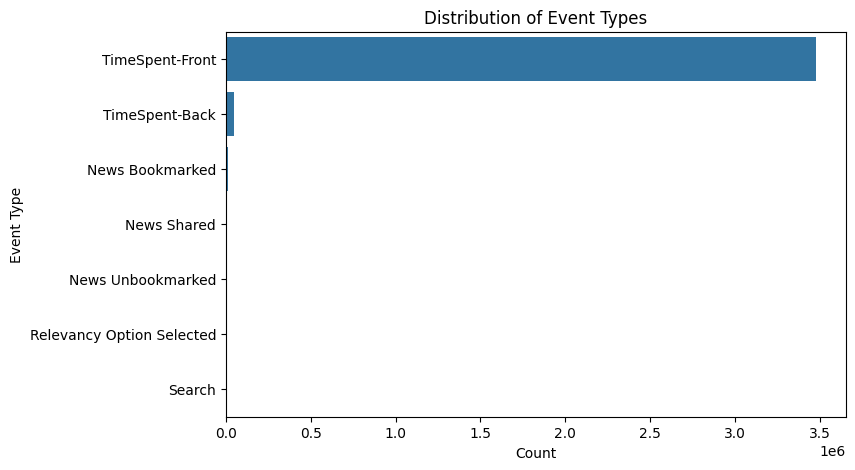

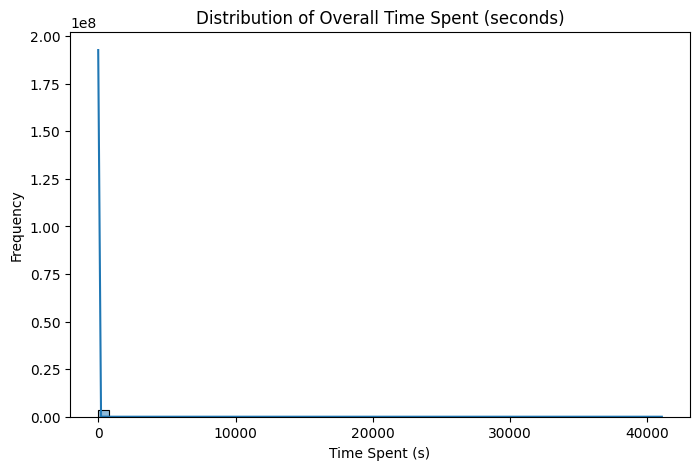

Average Time Spent per Event Type:
 event_type
TimeSpent-Back               41.184386
TimeSpent-Front               8.592099
News Shared                   0.000000
News Bookmarked               0.000000
Relevancy Option Selected     0.000000
News Unbookmarked             0.000000
Search                             NaN
Name: overallTimeSpent, dtype: float64


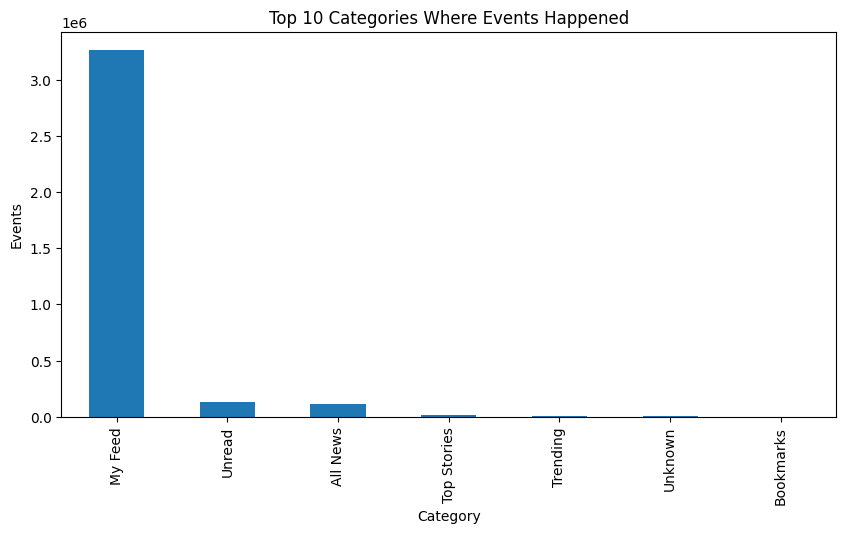

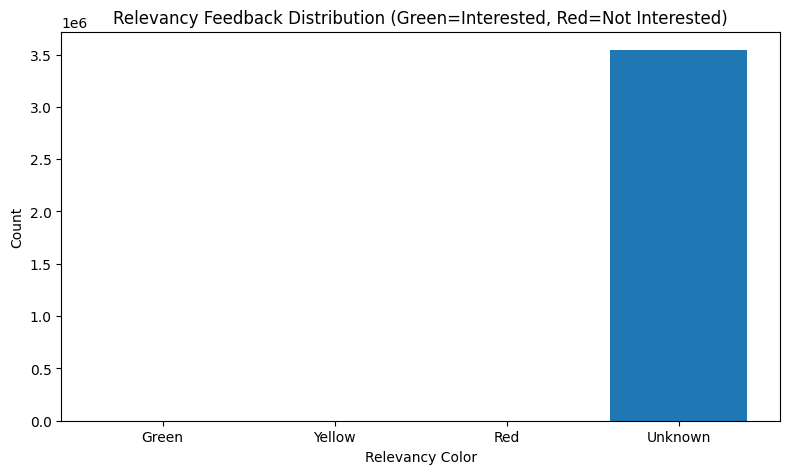

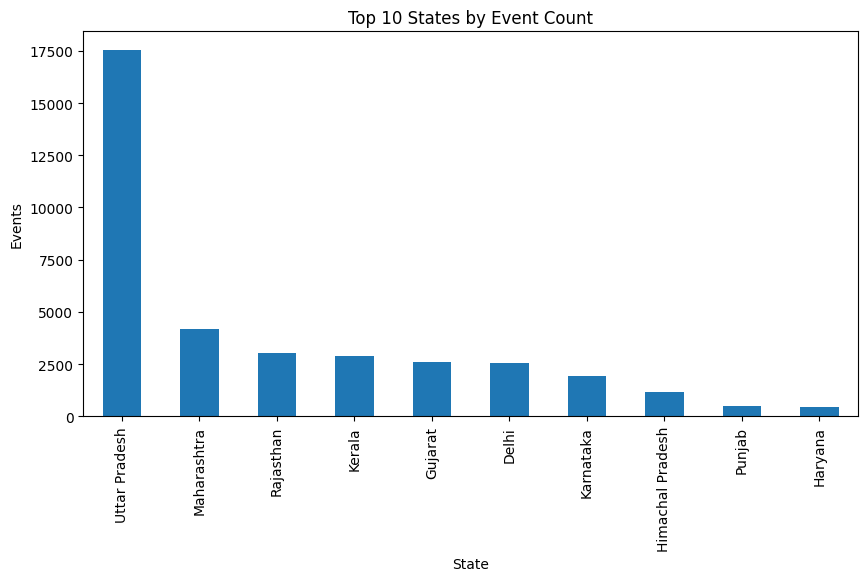

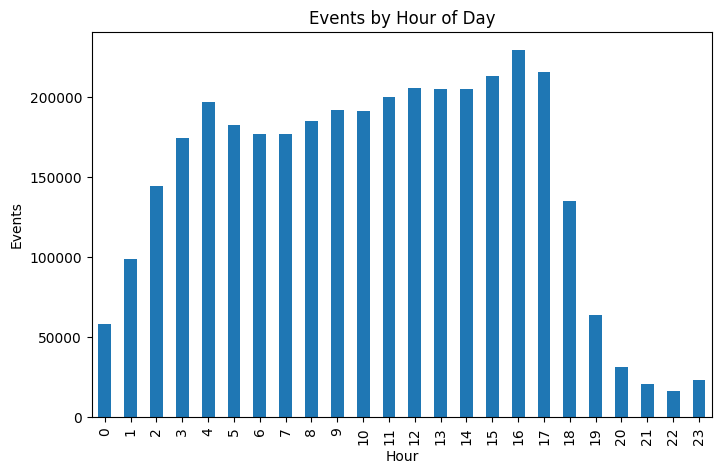

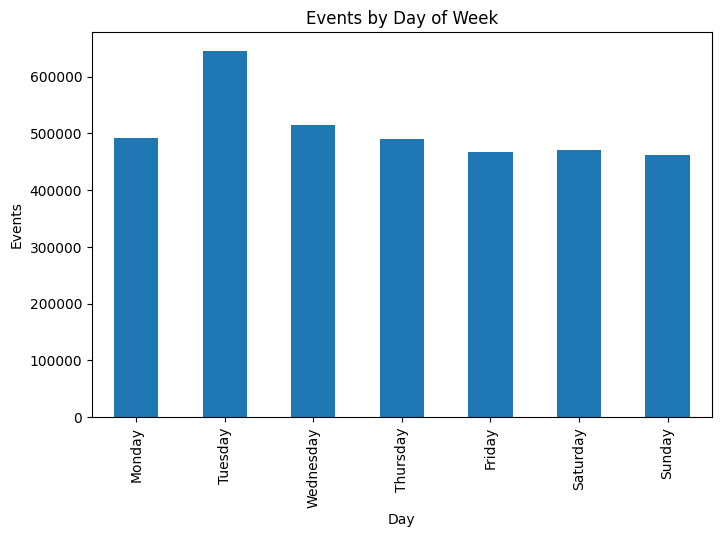

In [188]:
# Convert timestamp to datetime
event_df['eventTimestamp'] = pd.to_datetime(event_df['eventTimestamp'], errors='coerce', utc=True)
event_df['hour'] = event_df['eventTimestamp'].dt.hour
event_df['dayofweek'] = event_df['eventTimestamp'].dt.day_name()

# Ensure overallTimeSpent is numeric
event_df['overallTimeSpent'] = pd.to_numeric(event_df['overallTimeSpent'], errors='coerce')

# --------------------------
# 1. Event Type Distribution
# --------------------------
plt.figure(figsize=(8,5))
sns.countplot(y="event_type", data=event_df, order=event_df['event_type'].value_counts().index)
plt.title("Distribution of Event Types")
plt.xlabel("Count")
plt.ylabel("Event Type")
plt.show()

# --------------------------
# 2. Time Spent Distribution
# --------------------------
plt.figure(figsize=(8,5))
sns.histplot(event_df['overallTimeSpent'], bins=50, kde=True)
plt.title("Distribution of Overall Time Spent (seconds)")
plt.xlabel("Time Spent (s)")
plt.ylabel("Frequency")
plt.show()

# Avg time spent per event type
avg_time = event_df.groupby("event_type")['overallTimeSpent'].mean().sort_values(ascending=False)
print("Average Time Spent per Event Type:\n", avg_time)

# --------------------------
# 3. Category Context
# --------------------------
plt.figure(figsize=(10,5))
event_df['categoryWhenEventHappened'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Categories Where Events Happened")
plt.xlabel("Category")
plt.ylabel("Events")
plt.show()

# --------------------------
# 4. Relevancy Feedback
# --------------------------
# 1) Clean the column: lowercase, trim, and normalize unknowns
col = 'relevancy_color'
ec = event_df[col].astype(str).str.strip().str.lower()
ec = ec.replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
event_df[col] = ec.fillna('unknown')

# 2) Define a stable order (only keep those present)
preferred_order = ['green', 'yellow', 'red', 'unknown']
present = [c for c in preferred_order if c in event_df[col].unique()]

# 3) Count and reindex safely (no duplicates)
counts = event_df[col].value_counts(dropna=False)
counts = counts.reindex(present)

# 4) Plot (matplotlib)
plt.figure(figsize=(8,5))
plt.bar([c.title() for c in counts.index], counts.values)
plt.title("Relevancy Feedback Distribution (Green=Interested, Red=Not Interested)")
plt.xlabel("Relevancy Color")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
# --------------------------
# 5. Location Context
# --------------------------
plt.figure(figsize=(10,5))
event_df['state'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 States by Event Count")
plt.xlabel("State")
plt.ylabel("Events")
plt.show()


# --------------------------
# 6. Temporal Patterns
# --------------------------
# Hour of day
plt.figure(figsize=(8,5))
event_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Events by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Events")
plt.show()

# Day of week
plt.figure(figsize=(8,5))
event_df['dayofweek'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar')
plt.title("Events by Day of Week")
plt.xlabel("Day")
plt.ylabel("Events")
plt.show()



In [192]:
# ========== CONFIG ==========
TOP_N_SEARCH_TERMS = 20
TOP_N_STATES = 15
TOP_N_DISTRICTS = 15
RANDOM_SAMPLE_FOR_BOXPLOT = 200_000   # to speed up boxplot rendering on huge data
TIME_HIST_BINS = 60

# ========== HELPERS ==========

def _norm_str(s):
    return str(s).strip().lower() if pd.notna(s) else "unknown"


def clean_events_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # numeric coercions
    if 'overallTimeSpent' in df.columns:
        df['overallTimeSpent'] = pd.to_numeric(df['overallTimeSpent'], errors='coerce').fillna(0)
    else:
        df['overallTimeSpent'] = 0.0

    if 'cardViewPosition' in df.columns:
        df['cardViewPosition'] = pd.to_numeric(df['cardViewPosition'], errors='coerce')
    else:
        df['cardViewPosition'] = np.nan

    # categorical normalization
    cat_cols = [
        'event_type','categoryWhenEventHappened','relevancy_color','relevancy_topic',
        'searchTerm','state','locality','district','deviceId','hashId'
    ]
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].map(_norm_str)
        else:
            # create if missing to avoid key errors in plots
            df[c] = "unknown"


    df = df.dropna(subset=['deviceId','hashId','eventTimestamp'])

    return df

def data_quality_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'non_null': df.notna().sum(),
        'nulls': df.isna().sum(),
        'null_%': (df.isna().mean()*100).round(2),
        'unique': df.nunique(dropna=True)
    }).sort_index()
    return summary

# ========== MAIN EDA ==========

def eda_events_dashboard(event_df: pd.DataFrame):

    display_df = data_quality_summary(event_df)
    try:
        from IPython.display import display
        display(display_df)
    except Exception:
        print(display_df)
    # Clean
    df = clean_events_df(event_df)

    # Print quick facts
    print("ROWS:", len(df))
    print("Unique users (deviceId):", df['deviceId'].nunique())
    print("Unique items (hashId):", df['hashId'].nunique())
    print("\nData quality summary:")
    display_df = data_quality_summary(df)
    try:
        from IPython.display import display
        display(display_df)
    except Exception:
        print(display_df)

    # Ordering helpers
    dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dow_order = [d for d in dow_order if d in df['dayofweek'].unique()]

    # Sample for heavy plots (boxplot)
    df_box = df
    if len(df) > RANDOM_SAMPLE_FOR_BOXPLOT:
        df_box = df.sample(RANDOM_SAMPLE_FOR_BOXPLOT, random_state=42)

    # Figure
    plt.figure(figsize=(18, 16))
    plt.suptitle("Events EDA Dashboard", fontsize=20, fontweight='bold')

    # 1) Event type distribution
    ax1 = plt.subplot(3,3,1)
    order_types = df['event_type'].value_counts().index[:12]
    sns.countplot(data=df, y='event_type', order=order_types, ax=ax1)
    ax1.set_title("Event Type Distribution")
    ax1.set_xlabel("Count"); ax1.set_ylabel("Event Type")

    # 2) Time spent distribution (clipped for readability)
    ax2 = plt.subplot(3,3,2)
    clipped = df['overallTimeSpent'].clip(upper=df['overallTimeSpent'].quantile(0.99))
    sns.histplot(clipped, bins=TIME_HIST_BINS, kde=False, ax=ax2)
    ax2.set_title("Overall Time Spent (sec) — 99th pct clipped")
    ax2.set_xlabel("Seconds"); ax2.set_ylabel("Events")

    # 3) Time spent by event type (boxplot)
    ax3 = plt.subplot(3,3,3)
    top_et = df['event_type'].value_counts().index[:6]
    sns.boxplot(data=df_box[df_box['event_type'].isin(top_et)],
                x='event_type', y='overallTimeSpent', ax=ax3, showfliers=False)
    ax3.set_title("Time Spent by Event Type (no fliers)")
    ax3.set_xlabel(""); ax3.set_ylabel("Seconds"); ax3.tick_params(axis='x', rotation=30)

    # 4) Card view position (clip extreme)
    ax4 = plt.subplot(3,3,4)
    cvp = df['cardViewPosition'].dropna()
    cvp = cvp.clip(lower=0, upper=np.nanquantile(cvp, 0.99))
    sns.histplot(cvp, bins=50, ax=ax4)
    ax4.set_title("Card View Position (0–99th pct)")
    ax4.set_xlabel("Position"); ax4.set_ylabel("Events")

    # 5) Hour of day
    ax5 = plt.subplot(3,3,5)
    hour_counts = df['hour'].value_counts().sort_index()
    sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=ax5)
    ax5.set_title("Events by Hour of Day")
    ax5.set_xlabel("Hour"); ax5.set_ylabel("Events")

    # 6) Day of week
    ax6 = plt.subplot(3,3,6)
    dow_counts = df['dayofweek'].value_counts()
    dow_counts = dow_counts.reindex(dow_order)
    sns.barplot(x=dow_counts.index, y=dow_counts.values, ax=ax6)
    ax6.set_title("Events by Day of Week")
    ax6.set_xlabel(""); ax6.set_ylabel("Events"); ax6.tick_params(axis='x', rotation=15)

    # 7) Relevancy color
    ax7 = plt.subplot(3,3,7)
    rel_order = ['green','yellow','red','unknown']
    present = [c for c in rel_order if c in df['relevancy_color'].unique()]
    rel_counts = df['relevancy_color'].value_counts().reindex(present)
    sns.barplot(x=rel_counts.index, y=rel_counts.values, ax=ax7)
    ax7.set_title("Relevancy Feedback")
    ax7.set_xlabel(""); ax7.set_ylabel("Count")

    # 8) Top search terms
    ax8 = plt.subplot(3,3,8)
    st = df['searchTerm']
    top_search = st[st.ne('unknown')].value_counts().head(TOP_N_SEARCH_TERMS)
    if len(top_search):
        sns.barplot(y=top_search.index, x=top_search.values, ax=ax8)
        ax8.set_title(f"Top Search Terms (Top {TOP_N_SEARCH_TERMS})")
        ax8.set_xlabel("Count"); ax8.set_ylabel("")
    else:
        ax8.axis('off'); ax8.set_title("Top Search Terms — none available")

    # 9) Location (state/district) stacked view (choose one based on density)
    ax9 = plt.subplot(3,3,9)
    top_states = df['state'].value_counts().head(TOP_N_STATES)
    if len(top_states):
        sns.barplot(y=top_states.index, x=top_states.values, ax=ax9)
        ax9.set_title(f"Top States by Events (Top {TOP_N_STATES})")
        ax9.set_xlabel("Events"); ax9.set_ylabel("")
    else:
        ax9.axis('off'); ax9.set_title("Top States — none available")

    plt.tight_layout(rect=[0, 0, 1, 0.965])
    plt.savefig('eda_event.png')
    plt.show()

    # ------- concise numeric summary you can paste into a report -------
    print("\n--- Concise Summary ---")
    print(f"Date range: {df['eventTimestamp'].min()}  →  {df['eventTimestamp'].max()}")
    print("Event type mix:")
    print((df['event_type'].value_counts(normalize=True) * 100).round(2).add_suffix('%').to_string())
    print("\nTime spent (sec):")
    q = df['overallTimeSpent'].quantile([0, .25, .5, .75, .9, .99])
    print(q.to_string())
    if df['cardViewPosition'].notna().any():
        q2 = df['cardViewPosition'].dropna().quantile([0, .25, .5, .75, .9, .99])
        print("\nCardViewPosition:")
        print(q2.to_string())
    print("\nTop states:")
    print(df['state'].value_counts().head(10).to_string())
    if (df['searchTerm'] != 'unknown').any():
        print("\nTop search terms:")
        print(df.loc[df['searchTerm']!='unknown','searchTerm'].value_counts().head(10).to_string())
    return df
    




,dtype,non_null,nulls,null_%,unique
cardViewPosition,float64,3543038,1123,0.03,842
categoryWhenEventHappened,object,3542475,1686,0.05,7
dayofweek,object,3544161,0,0.00,7
deviceId,object,3544161,0,0.00,8977
district,object,38467,3505694,98.91,60
eventTimestamp,"datetime64[ns, UTC]",3544161,0,0.00,1662517
event_type,object,3544161,0,0.00,7
hashId,object,3544154,7,0.00,14622
hour,int32,3544161,0,0.00,24
locality,object,45370,3498791,98.72,71


ROWS: 3544161
Unique users (deviceId): 8977
Unique items (hashId): 14622

Data quality summary:


,dtype,non_null,nulls,null_%,unique
cardViewPosition,float64,3543038,1123,0.03,842
categoryWhenEventHappened,object,3544161,0,0.00,7
dayofweek,object,3544161,0,0.00,7
deviceId,object,3544161,0,0.00,8977
district,object,3544161,0,0.00,61
eventTimestamp,"datetime64[ns, UTC]",3544161,0,0.00,1662517
event_type,object,3544161,0,0.00,7
hashId,object,3544161,0,0.00,14622
hour,int32,3544161,0,0.00,24
locality,object,3544161,0,0.00,71


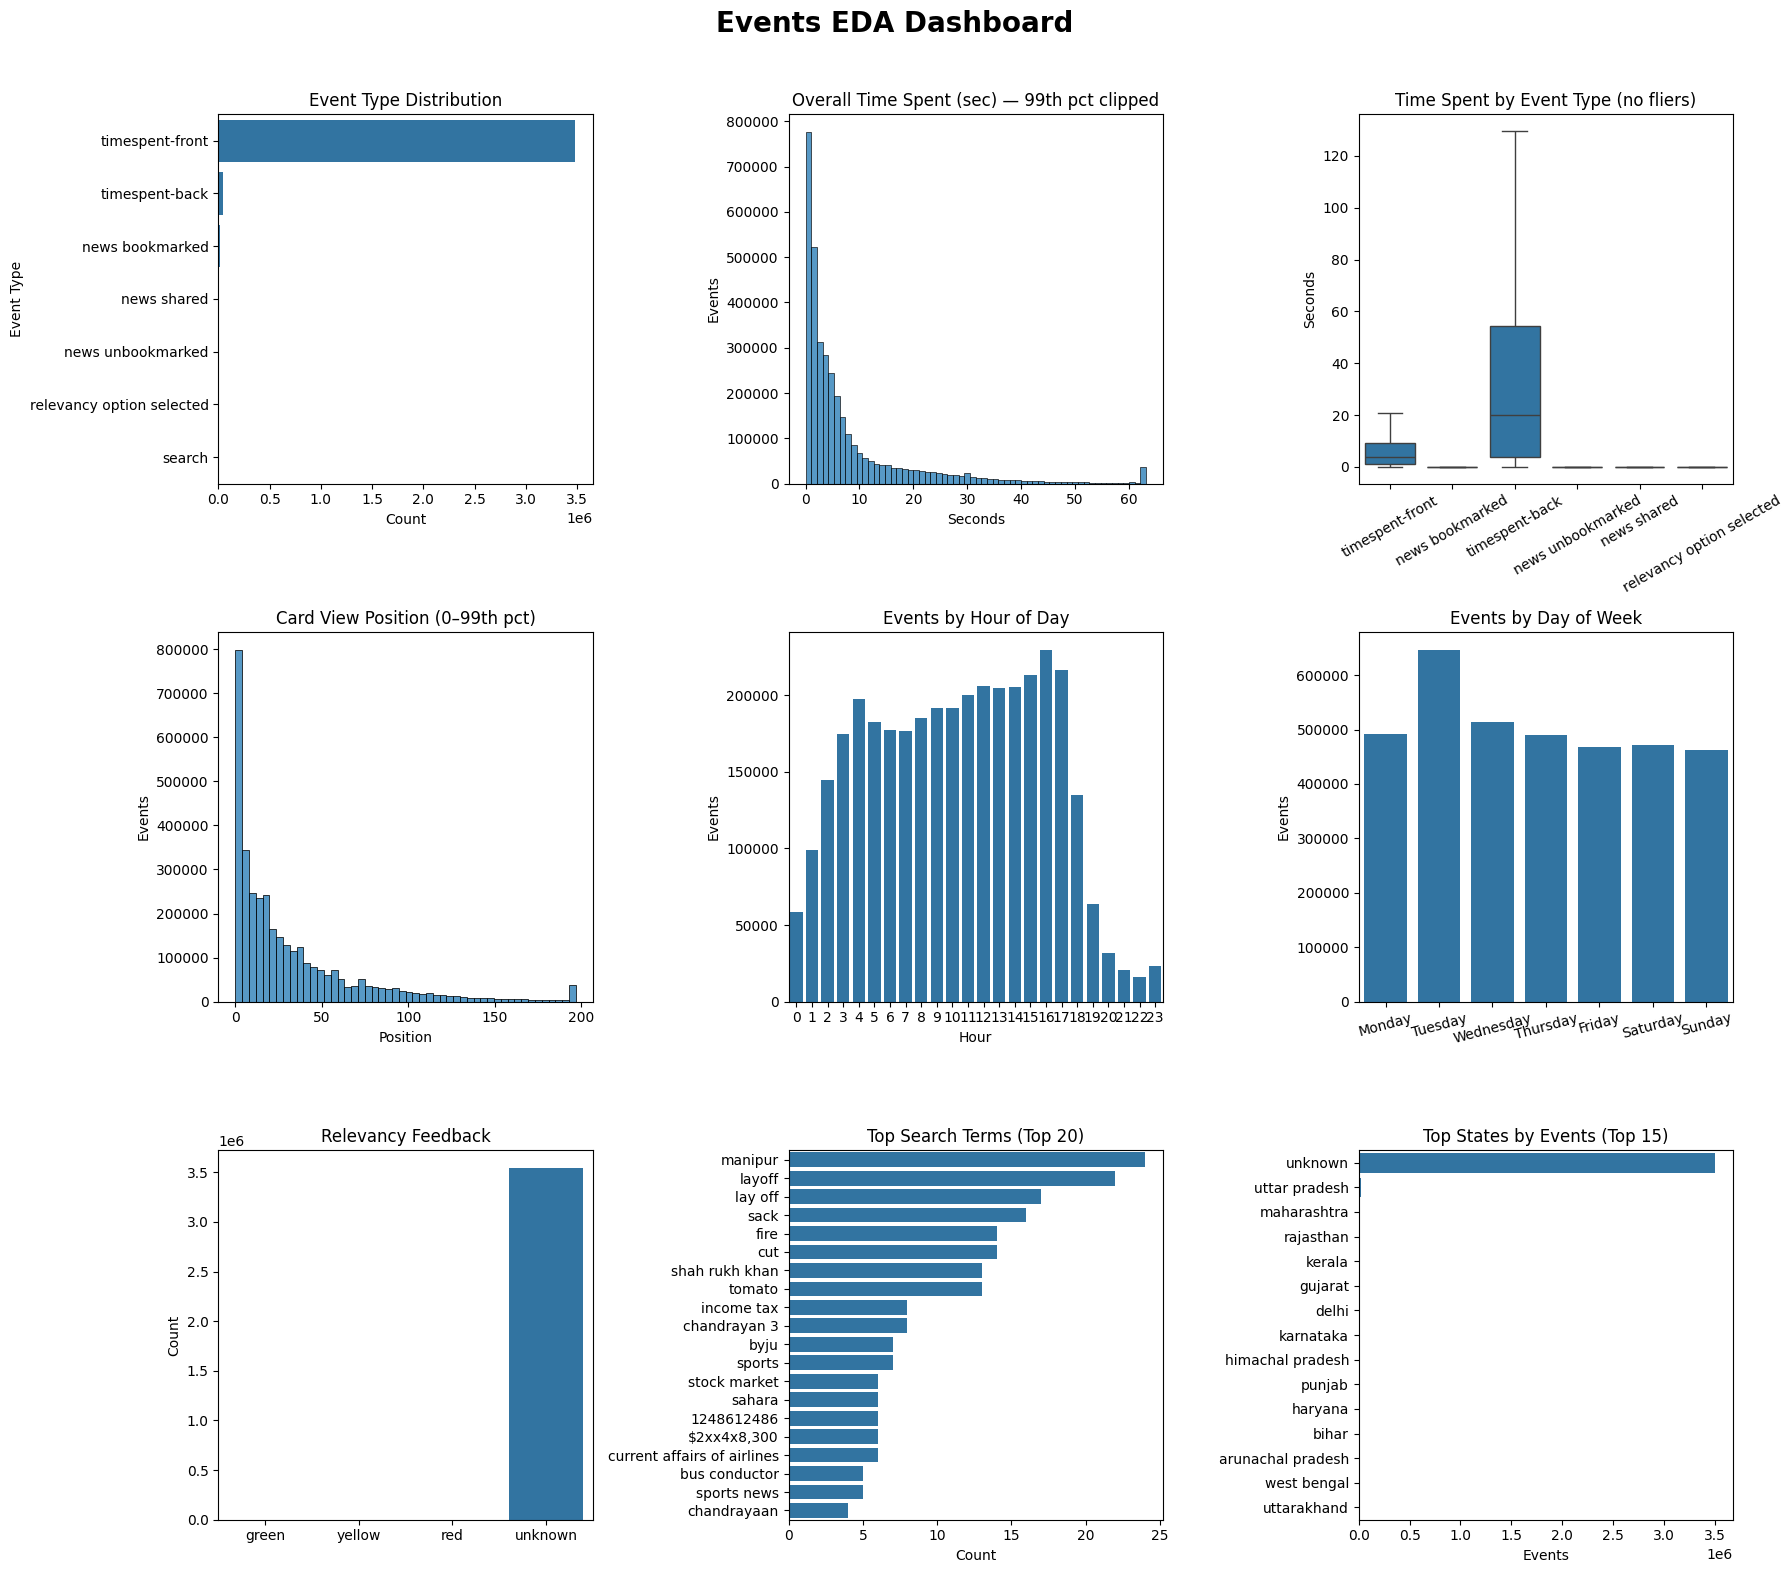


--- Concise Summary ---
Date range: 2023-06-27 00:00:07+00:00  →  2023-07-25 23:59:59+00:00
Event type mix:
event_type
timespent-front%              98.19
timespent-back%                1.27
news bookmarked%               0.31
news shared%                   0.10
news unbookmarked%             0.06
relevancy option selected%     0.04
search%                        0.03

Time spent (sec):
0.00     0.0000
0.25     1.1990
0.50     3.7450
0.75     9.2420
0.90    23.0360
0.99    63.1694

CardViewPosition:
0.00     -1.0
0.25      4.0
0.50     18.0
0.75     44.0
0.90     86.0
0.99    197.0

Top states:
state
unknown             3505694
uttar pradesh         17556
maharashtra            4168
rajasthan              3019
kerala                 2876
gujarat                2595
delhi                  2566
karnataka              1922
himachal pradesh       1142
punjab                  492

Top search terms:
searchTerm
manipur           24
layoff            22
lay off           17
sack              

In [193]:
event_df = eda_events_dashboard(event_df)

# Training Content

In [30]:
# List to hold the valid rows as pandas Series
rows = []

# Open the CSV file
with open("../test_data/test_data/training_content/train_data.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', delimiter=',', skipinitialspace=True)
    
    # Read the header
    headers = next(reader)
    i=2
    skiprows = []
    # Iterate through each row
    for row in reader:
        if i in skiprows:
            continue
        # Handling rows with more than expected columns (like embedded commas inside quotes)
        if len(row) > 12:  # If there are more columns than expected, merge columns
            # Combine the fields that may have extra commas inside quotes
            row[1] = " ".join(row[2:9]) 
            row[2] = " ".join(row[2:9]) 
            
            new_row = row[:3] + (row[-9:])
            row = new_row
            
        if len(row) == 12:
            # Convert the row into a Pandas Series and append to the list
            row_series = pd.Series(row, index=headers)
            rows.append(row_series)
        else:
            # If the row doesn't have 12 fields, print it for debugging
            print(f"Skipping row #{i + 2}, #{i+3} (invalid columns): {row}")
            skiprows.append(i)
            skiprows.append(i+1)
            i+=1
        i+=1

# After processing all rows, convert the list of Series into a DataFrame
training_content_df = pd.DataFrame(rows)



Skipping row #528, #529 (invalid columns): ['fe4jv48w-1', 'भीम आर्मी चीफ चंद्रशेखर आज़ाद ने खुद पर हुए हालिया हमले की सीबीआई जांच की मांग की', 'भीम आर्मी चीफ व आज़ाद समाज पार्टी के प्रमुख चंद्रशेखर आज़ाद ने खुद पर हुए हालिया हमले की ज्यूडिशियल व सीबीआई जांच की मांग की है। आज़ाद ने कहा, \\हमला एक साज़िश है इसके पीछे कई बड़े लोग व अधिकारी शामिल हो सकते हैं।\\"']
Skipping row #530, #531 (invalid columns): ['गौरतलब है', 'सहारनपुर में पिछले बुधवार (28 जून) को आज़ाद पर जानलेवा हमला हुआ था।"', 'NEWS', '61efae73573ea241dc329e00', 'politics,national', '', '', '2023-07-04T05:07:55.000Z', '2023-07-04T05:07:55.000Z', 'hindi', 'ANI']
Skipping row #1969, #1970 (invalid columns): ['znxzjepi-1', 'Priyanka lying, farmers being given ₹12,000: MP CM', 'Madhya Pradesh CM Shivraj Singh Chouhan refuted Congress leader Priyanka Gandhi\'s claim that farmers were unable to make ₹27 a day in the state. Chouhan said, “₹6,000 from the Prime Minister and ₹6,000 from me are being directly deposited into the bank acco

In [173]:
training_content_df['createdAt'] = pd.to_datetime(training_content_df["createdAt"])

In [31]:
filtered_event_df = event_df[event_df["hashId"].isin(training_content_df['hashid'].values)]

In [32]:
cutoff_date = filtered_event_df["eventTimestamp"].quantile(0.8)  # 80% past for training, 20% recent for validation
train_df = filtered_event_df[filtered_event_df["eventTimestamp"] <= cutoff_date]
val_df   = filtered_event_df[filtered_event_df["eventTimestamp"] > cutoff_date]

In [33]:
cutoff_date

Timestamp('2023-07-20 03:31:52+0000', tz='UTC')

In [35]:
import numpy as np
import pandas as pd

# --- configurable weights ---
EVENT_WEIGHTS = {
    "timespent_front": 0.0,   # time is handled via a separate scaled term
    "timespent_back":  0.0,   # time is handled via a separate scaled term
    "news_bookmarked": 3.0,
    "news_shared":     2.0,
    "news_unbookmarked": -2.0,
    #search/relevancy
    "search":          0.5,
    "relevancy_green": 1.5,
    "relevancy_yellow":0.3,
    "relevancy_red":  -1.5,
    "other":           0.1,
}

# time scaling params (seconds)
TIME_CLIP = 120.0   # cap time after testing
TIME_SCALE = 1.5

# small utility to standardize text
def _norm(x):
    return str(x).strip().lower() if pd.notna(x) else "unknown"

def add_interaction_score(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # normalize columns we’ll use
    for c in ["event_type", "relevancy_color"]:
        if c in df.columns:
            df[c] = df[c].map(_norm)

    # numeric time
    df["overallTimeSpent"] = pd.to_numeric(df.get("overallTimeSpent", 0), errors="coerce").fillna(0)

    # map common variants
    et = df["event_type"]
    event_key = np.where(et.str.contains("timespent-front"), "timespent_front",
                 np.where(et.str.contains("timespent-back"),  "timespent_back",
                 np.where(et.str.contains("bookmarked") & ~et.str.contains("un"), "news_bookmarked",
                 np.where(et.str.contains("unbookmarked"), "news_unbookmarked",
                 np.where(et.str.contains("shared"), "news_shared",
                 np.where(et.str.contains("search"), "search", "other"))))))

    # base event weight
    df["event_weight"] = pd.Series(event_key, index=df.index).map(EVENT_WEIGHTS).fillna(EVENT_WEIGHTS["other"])


    rel = df.get("relevancy_color", "unknown")
    rel_key = np.where(rel == "green", "relevancy_green",
              np.where(rel == "yellow", "relevancy_yellow",
              np.where(rel == "red", "relevancy_red", None)))
    rel_weight = pd.Series(rel_key).map(EVENT_WEIGHTS).fillna(0.0)
    df["relevancy_weight"] = rel_weight

    # time component: clip -> log1p -> scale
    t = df["overallTimeSpent"].clip(lower=0, upper=TIME_CLIP)
    time_component = np.log1p(t / 5.0) * TIME_SCALE   # /5 smooths; tweak as needed
    df["time_weight"] = time_component

    # final interaction score (sum of components)
    df["interaction_score"] = df["event_weight"] + df["relevancy_weight"] + df["time_weight"]

    return df


In [36]:
train_df = add_interaction_score(train_df)

In [37]:
train_df.columns

Index(['deviceId', 'event_type', 'eventTimestamp', 'hashId',
       'categoryWhenEventHappened', 'cardViewPosition', 'overallTimeSpent',
       'searchTerm', 'relevancy_color', 'relevancy_topic', 'state', 'locality',
       'district', 'hour', 'dayofweek', 'event_weight', 'relevancy_weight',
       'time_weight', 'interaction_score'],
      dtype='object')

# Model Building

# Method 1

In [38]:

# --- 1) Load model ---
model = SentenceTransformer("intfloat/multilingual-e5-base")

def embed_text(text, prefix="passage: "):
    return model.encode([prefix + text], normalize_embeddings=True)[0]

# --- 2) Precompute & cache embeddings per article ---
def precompute_embeddings(training_content_df):
    """
    Precompute title/content/metadata embeddings for all articles.
    Returns a dict: {hashid: {"title_vec":..., "content_vec":..., "metadata_vec":..., "lang":...}}
    """
    cache = {}
    for _, art in training_content_df.iterrows():
        hashid = art["hashid"]

        title_vec = embed_text(str(art.get("title", "")))
        content_vec = embed_text(str(art.get("content", "")))
        metadata_str = "".join([
            str(art.get("newsType", "")),
            str(art.get("hashtags", "")),
            str(art.get("newsDistrict", "")),
            str(art.get("newsLanguage", "")),
            str(art.get("sourceName", "")),
        ])
        metadata_vec = embed_text(metadata_str)

        cache[hashid] = {
            "title_vec": title_vec.astype("float32"),
            "content_vec": content_vec.astype("float32"),
            "metadata_vec": metadata_vec.astype("float32"),
            "lang": art.get("newsLanguage", "")
        }
    return cache

# --- 3) Build article vector with tunable weights ---
def build_article_vector(embeddings, w_title=0.2, w_content=0.3, w_metadata=0.5):
    """Combine embeddings with weights into a single vector."""
    vec = (w_title * embeddings["title_vec"] +
           w_content * embeddings["content_vec"] +
           w_metadata * embeddings["metadata_vec"])
    return vec.astype("float32")

# --- 4) Build FAISS index given weight settings ---
def build_faiss_index(embedding_cache, w_title=0.2, w_content=0.3, w_metadata=0.5):
    article_vecs, meta = [], []
    for hashid, embs in embedding_cache.items():
        v = build_article_vector(embs, w_title, w_content, w_metadata)
        article_vecs.append(v)
        meta.append({"id": hashid, "lang": embs["lang"]})

    mat = np.vstack(article_vecs).astype("float32")
    faiss.normalize_L2(mat)

    d = mat.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(mat)

    return index, meta

/home/atonarp/miniconda3/envs/langchain_test/lib/python3.13/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [39]:
# --- Example usage ---
# Step 1: Precompute once
embedding_cache = precompute_embeddings(training_content_df)

In [117]:
# Step 2: Try different hyperparameters quickly
# index1, meta1 = build_faiss_index(embedding_cache, w_title=0.2, w_content=0.3, w_metadata=0.5)
index1, meta1 = build_faiss_index(embedding_cache, w_title=0.2, w_content=0.5, w_metadata=0.3)

# Top k per user

In [143]:
k =20
# Filter out unknown hasid
filtered_df = train_df[train_df["hashId"] != "unknown"]


# Sort by interaction_score within deviceid
sorted_df = filtered_df.sort_values(["deviceId", "interaction_score"], ascending=[True, False])

# Take top k per deviceid
topk_df = sorted_df.groupby("deviceId").head(k)

# Save to dictionary
result_dict = (
    topk_df.groupby("deviceId")
    .apply(lambda g: g[["hashId", "event_type", "interaction_score"]].to_dict(orient="records"))
    .to_dict()
)


/tmp/ipykernel_57169/59729787.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["hashId", "event_type", "interaction_score"]].to_dict(orient="records"))


# For cold start take polularity of news as preference

In [144]:
popular_k = 20  # top k

# 1) Aggregate counts and scores
agg_df = (
    train_df.groupby("hashId")
    .agg(
        count=("hashId", "size"),
        interaction_score=("interaction_score", "sum"),
        last_ts=("eventTimestamp", "max")
    )
    .reset_index()
)

# 2) Normalise count and interaction_score
agg_df["count_norm"] = agg_df["count"] / agg_df["count"].max()
agg_df["score_norm"] = agg_df["interaction_score"] / agg_df["interaction_score"].max()

# 3) Time-based normalisation
max_date = agg_df["last_ts"].max()
# recency = 1 - (age_in_days / max_age_in_days)
agg_df["age_days"] = (max_date - agg_df["last_ts"]).dt.days
max_age = agg_df["age_days"].max() if agg_df["age_days"].max() > 0 else 1
agg_df["recency_norm"] = 1 - (agg_df["age_days"] / max_age)

w_count, w_score, w_time = 0.2, 0.1, 0.7
agg_df["popularity_score"] = (
    w_count * agg_df["count_norm"] +
    w_score * agg_df["score_norm"] +
    w_time  * agg_df["recency_norm"]
)

# 5) Top-k
topk_df = agg_df.sort_values("popularity_score", ascending=False).head(popular_k)

# Extract hashIds
topk_hashids = topk_df["hashId"].tolist()

In [42]:
# --- 1) Build a lookup dict from training_content_df ---
articles_lookup = training_content_df.set_index("hashid").to_dict(orient="index")

# Validating data

In [138]:
# --- 2) Build per-device profile vector ---
def build_device_vector(deviceid, result_dict, articles_dict):
    """Average embedding from top-k hashids for one deviceid."""
    hashids = [r["hashId"] for r in result_dict.get(deviceid, [])]
    vecs = []
    if len(hashids) == 0:
        hashids = topk_hashids   # cold start
    for hid in hashids:
        article = articles_dict.get(hid)
        if article:
            vec = build_article_vector(embedding_cache[hid])  # from your earlier code
            vecs.append(vec)
    if not vecs:
        return None
    avg_vec = np.mean(np.stack(vecs), axis=0)
    faiss.normalize_L2(avg_vec.reshape(1, -1))  # normalize for cosine similarity
    return avg_vec

# --- 3) Query FAISS ---
def recommend_for_device(deviceid, result_dict, articles_dict, index, topn=10):
    """Return top-n FAISS recommendations for a given deviceid."""
    target_vec = build_device_vector(deviceid, result_dict, articles_dict)
    if target_vec is None:
        return [], []
    D, I = index.search(target_vec.reshape(1, -1).astype("float32"), topn)
    return I,D
    
def get_recommendations(deviceid, result_dict, article_lookup, index, meta, topn=10):
    """Return recommended hashids for a deviceid."""
    I, D = recommend_for_device(deviceid, result_dict, article_lookup, index, topn=topn)

    recs_with_scores = []
    now = pd.to_datetime(training_content_df['createdAt'].max())
    tau_hours = 48
    for j, idx in enumerate(I[0]):
        hid = meta[idx]["id"]
        score = D[0][j]

        # fetch created_at timestamp for this article
        created_at = article_lookup[hid]["createdAt"] if hid in article_lookup.keys() else None
        
        if created_at is not None:
            age_hours = (now - pd.to_datetime(created_at)).total_seconds() / 3600.0
            # exponential decay
            time_weight = math.exp(-age_hours / tau_hours)
        else:
            time_weight = 1.0  # no penalty if timestamp missing

        adjusted_score = score * time_weight
        recs_with_scores.append((hid, adjusted_score))

    # sort by adjusted score
    recs_sorted = sorted(recs_with_scores, key=lambda x: x[1], reverse=True)

    # return topn after reranking
    return [hid for hid, _ in recs_sorted[:topn]]
    
    # Map FAISS indices back to hashids
    recs = [meta[i]["id"] for i in I[0]]
    return recs
    

In [130]:
val_df = add_interaction_score(val_df)

In [131]:
# Sort val_df by interaction_score within each deviceid
val_sorted = val_df.sort_values(["deviceId", "interaction_score"], ascending=[True, False])

# Group and save as dict: {deviceid: [hashid1, hashid2, ...]} sorted
val_ground_truth = (
    val_sorted.groupby("deviceId")["hashId"]
    .apply(list)
    .to_dict()
)

# If you also want (hashid, score) tuples instead of just hashid:
val_ground_truth_with_scores = (
    val_sorted.groupby("deviceId")[["hashId", "interaction_score"]]
    .apply(lambda g: list(zip(g["hashId"], g["interaction_score"])))
    .to_dict()
)

In [132]:
def recall_at_k(recommended, ground_truth, k):
    if not ground_truth: 
        return 0.0
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(ground_truth))
    return hits / len(set(ground_truth))

def precision_at_k(recommended, ground_truth, k):
    if not recommended[:k]:
        return 0.0
    hits = len(set(recommended[:k]) & set(ground_truth))
    return hits / k

def ndcg_at_k(recommended, ground_truth, k):
    def dcg(scores):
        return sum(score / np.log2(idx + 2) for idx, score in enumerate(scores))
    
    recommended_at_k = recommended[:k]
    scores = [1 if r in ground_truth else 0 for r in recommended_at_k]
    dcg_val = dcg(scores)
    ideal_scores = [1] * min(len(ground_truth), k)
    idcg = dcg(ideal_scores)
    return dcg_val / idcg if idcg > 0 else 0.0


In [168]:
def plot_device_metrics(device_metrics, topn=50):
    df = pd.DataFrame.from_dict(device_metrics, orient="index").reset_index().rename(columns={"index": "deviceid"})
    recall_col = f"Recall{topn}"
    precision_col = f"Precision{topn}"

    plt.figure(figsize=(10,6))
    plt.scatter(df[recall_col], df[precision_col], alpha=0.6)
    plt.xlabel(recall_col)
    plt.ylabel(precision_col)
    plt.title(f"Per-device {precision_col} vs {recall_col}")
    plt.grid(True)
    
    return plt

In [ ]:
def evaluate_per_device(index, meta, result_dict, training_df, val_ground_truth, topn=50):
    device_metrics = {}
    recalls, precisions, ndcgs = [], [], []

      # for overall recall/precision
    total_relevant, total_recommended, total_hits = 0, 0, 0
    
    for deviceid, ground_truth in val_ground_truth.items():
        # Get recommendations
        recommended = get_recommendations(deviceid, result_dict, training_df, index, meta, topn=topn)

        
        # Compute metrics
        rec = recall_at_k(recommended, ground_truth, topn)
        prec = precision_at_k(recommended, ground_truth, topn)
        ndcg = ndcg_at_k(recommended, ground_truth, topn)
        
        # Save per-device
        device_metrics[deviceid] = {
            "Recall{}".format(topn): rec,
            "Precision{}".format(topn): prec,
            "NDCG{}".format(topn): ndcg,
            "ground_truth": ground_truth,
            "recommended": recommended
        }
        
        recalls.append(rec)
        precisions.append(prec)
        ndcgs.append(ndcg)

        # Update overall stats
        hits = len(set(recommended) & set(ground_truth))
        total_hits += hits
        total_recommended += min(topn, len(recommended))
        total_relevant += len(set(ground_truth))
    
    # Aggregate metrics
    aggregate = {
        "Recall{}".format(topn): np.mean(recalls),
        "Precision{}".format(topn): np.mean(precisions),
        "NDCG{}".format(topn): np.mean(ndcgs),
        "Overall_Recall": total_hits / total_relevant if total_relevant > 0 else 0,
        "Overall_Precision": total_hits / total_recommended if total_recommended > 0 else 0
    }
    
    return aggregate, device_metrics




# Example usage
agg_metrics, per_device = evaluate_per_device(index1, meta1, result_dict, articles_lookup, val_ground_truth, topn=50)


print("Aggregate metrics:", agg_metrics)

# Inspect a few devices
for dev, metrics in list(per_device.items())[:3]:  # first 3 devices
    print("\nDevice:", dev)
    print("Metrics:", {k: round(v, 3) for k, v in metrics.items() if isinstance(v, float)})
    print("Ground truth:", metrics["ground_truth"])
    print("Recommended:", metrics["recommended"])


In [ ]:
# ---- MLflow logging ----
with mlflow.start_run(run_name='News Recommendation'):
    params = {
                "weights": {"title": 0.2, "content": 0.5, "metadata": 0.3},
                "tau_hours": 48,
                "topn": 50,
                "topk": 20
            }
    if params:
        mlflow.log_params(params)
    mlflow.log_metrics(agg_metrics)

    save_dir="results"
    # Save per_device dict as JSON artifact
    os.makedirs(save_dir, exist_ok=True)
    per_device_path = os.path.join(save_dir, "per_device.json")
    with open(per_device_path, "w") as f:
        json.dump(per_device, f)
    mlflow.log_artifact(per_device_path)

    # Save per-device scatter plot
    df_metrics = plot_device_metrics(per_device, topn=50)
    plot_path = os.path.join(save_dir, "precision_recall_scatter.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

# Method -2 

In [176]:
validation_hashids = training_content_df[training_content_df['createdAt'] >= cutoff_date]['hashid'].values

In [178]:

# --- 4) Build FAISS index given weight settings ---
def build_validation_faiss_index(embedding_cache, w_title=0.2, w_content=0.3, w_metadata=0.5):
    article_vecs, meta = [], []
    for hashid, embs in embedding_cache.items():
        if hashid not in validation_hashids:
            continue
        v = build_article_vector(embs, w_title, w_content, w_metadata)
        article_vecs.append(v)
        meta.append({"id": hashid, "lang": embs["lang"]})

    mat = np.vstack(article_vecs).astype("float32")
    faiss.normalize_L2(mat)

    d = mat.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(mat)

    return index, meta

In [179]:
index2, meta2 = build_validation_faiss_index(embedding_cache, w_title=0.2, w_content=0.5, w_metadata=0.3)

In [ ]:
def evaluate_per_device(index, meta, result_dict, training_df, val_ground_truth, topn=50):
    device_metrics = {}
    recalls, precisions, ndcgs = [], [], []

      # for overall recall/precision
    total_relevant, total_recommended, total_hits = 0, 0, 0
    
    for deviceid, ground_truth in val_ground_truth.items():
        # Get recommendations
        recommended = get_recommendations(deviceid, result_dict, training_df, index, meta, topn=topn)

        
        # Compute metrics
        rec = recall_at_k(recommended, ground_truth, topn)
        prec = precision_at_k(recommended, ground_truth, topn)
        ndcg = ndcg_at_k(recommended, ground_truth, topn)
        
        # Save per-device
        device_metrics[deviceid] = {
            "Recall{}".format(topn): rec,
            "Precision{}".format(topn): prec,
            "NDCG{}".format(topn): ndcg,
            "ground_truth": ground_truth,
            "recommended": recommended
        }
        
        recalls.append(rec)
        precisions.append(prec)
        ndcgs.append(ndcg)

        # Update overall stats
        hits = len(set(recommended) & set(ground_truth))
        total_hits += hits
        total_recommended += min(topn, len(recommended))
        total_relevant += len(set(ground_truth))
    
    # Aggregate metrics
    aggregate = {
        "Recall{}".format(topn): np.mean(recalls),
        "Precision{}".format(topn): np.mean(precisions),
        "NDCG{}".format(topn): np.mean(ndcgs),
        "Overall_Recall": total_hits / total_relevant if total_relevant > 0 else 0,
        "Overall_Precision": total_hits / total_recommended if total_recommended > 0 else 0
    }
    
    return aggregate, device_metrics




# Example usage
agg_metrics, per_device = evaluate_per_device(index2, meta2, result_dict, articles_lookup, val_ground_truth, topn=50)


print("Aggregate metrics:", agg_metrics)

# Inspect a few devices
for dev, metrics in list(per_device.items())[:3]:  # first 3 devices
    print("\nDevice:", dev)
    print("Metrics:", {k: round(v, 3) for k, v in metrics.items() if isinstance(v, float)})
    print("Ground truth:", metrics["ground_truth"])
    print("Recommended:", metrics["recommended"])


🏃 View run News Recommendation(M-2) at: http://127.0.0.1:5000/#/experiments/483396273814098465/runs/b30d6248226f48e0916e2ac9506c9afd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/483396273814098465


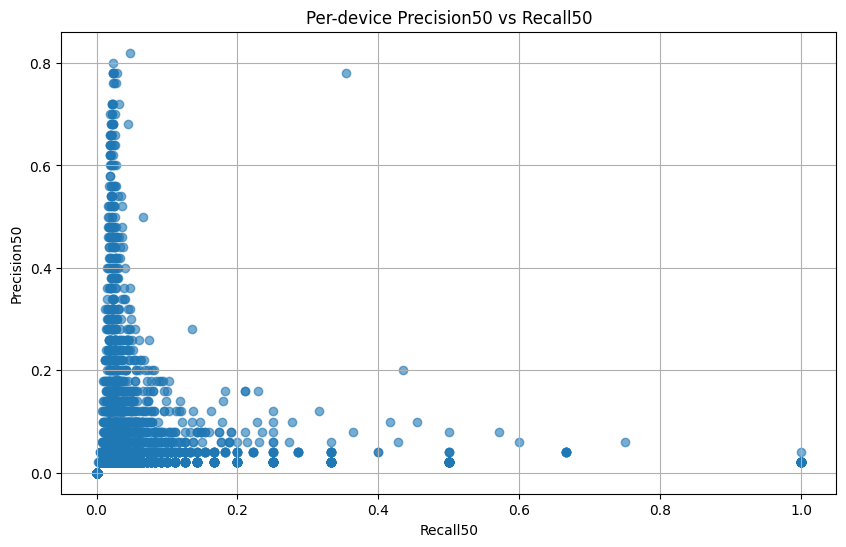

In [181]:
# ---- MLflow logging ----
with mlflow.start_run(run_name='News Recommendation(M-2)'):
    params = {
                "weights": {"title": 0.2, "content": 0.5, "metadata": 0.3},
                "tau_hours": 48,
                "topn": 50,
                "topk": 20
            }
    if params:
        mlflow.log_params(params)
    mlflow.log_metrics(agg_metrics)

    save_dir="results"
    # Save per_device dict as JSON artifact
    os.makedirs(save_dir, exist_ok=True)
    per_device_path = os.path.join(save_dir, "per_device.json")
    with open(per_device_path, "w") as f:
        json.dump(per_device, f)
    mlflow.log_artifact(per_device_path)

    # Save per-device scatter plot
    df_metrics = plot_device_metrics(per_device, topn=50)
    plot_path = os.path.join(save_dir, "precision_recall_scatter.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

# Testing : Using Approach 2 to generate recommendations on useen news (testing content) for each device

In [195]:

# List to hold the valid rows as pandas Series
rows = []

# Open the CSV file
with open("../test_data/test_data/testing_content/test_data.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', delimiter=',', skipinitialspace=True)
    
    # Read the header
    headers = next(reader)
    i=2
    skiprows = []
    # Iterate through each row
    for row in reader:
        if i in skiprows:
            continue
        # Handling rows with more than expected columns (like embedded commas inside quotes)
        if len(row) > 12:  # If there are more columns than expected, merge columns
            # Combine the fields that may have extra commas inside quotes
            row[1] = " ".join(row[2:9])  # Adjust this slice based on your columns
            row[2] = " ".join(row[2:9])  # Adjust this slice based on your columns
            
            new_row = row[:3] + (row[-9:])
            row = new_row
            
        if len(row) == 12:
            # Convert the row into a Pandas Series and append to the list
            row_series = pd.Series(row, index=headers)
            rows.append(row_series)
        else:
            # If the row doesn't have 12 fields, print it for debugging
            print(f"Skipping row #{i + 2}, #{i+3} (invalid columns): {row}")
            skiprows.append(i)
            skiprows.append(i+1)
            i+=1
        i+=1

# After processing all rows, convert the list of Series into a DataFrame
testing_df = pd.DataFrame(rows)



Skipping row #941, #942 (invalid columns): ['wgyg2ycp-1', 'चीन ने पाकिस्तान को $2.4 अरब का कर्ज़ चुकाने के लिए अगले 2 वित्तीय वर्षों तक की दी छूट', 'पाकिस्तान के वित्त मंत्री इसहाक डार ने गुरुवार को बताया, \\चीनी एक्ज़िम बैंक ने $2.4 अरब के कर्ज़ की मूल राशि चुकाने पर ']
Skipping row #943, #944 (invalid columns): ['(पाकिस्तान को) 2 साल की राहत दी है। यह अगले 2 वित्तीय वर्षों में देय है।\\" उन्होंने आगे कहा', '\\"पाकिस्तान को वित्तीय वर्ष 2023-24 में $1.2 अरब व वित्तीय वर्ष 2024-25 में $1.2 अरब चुकाने थे।\\""', 'NEWS', '61efaefad4382134432b6184', 'world,national', '', '', '2023-07-27T10:11:48.000Z', '2023-07-27T11:13:07.831Z', 'hindi', 'भाषा']
Skipping row #975, #976 (invalid columns): ['unuoouua-1', "Why so negative: TMC on PM Modi's remarks against INDIA alliance", 'Reacting to PM Narendra Modi\'s remarks comparing Opposition INDIA with Indian Mujahideen and PFI, TMC\'s Derek O\'Brien criticised him, asking why he was being so \\negative\\". \\"Hello PM Narendra Modi', "you're at it ag

In [196]:
testing_embedding_cache =  precompute_embeddings(testing_df)

In [246]:
overall_df = pd.concat([training_content_df, testing_df], axis=0, ignore_index=True)

In [248]:
overall_articles_lookup = overall_df.set_index("hashid").to_dict(orient="index")

# Top k per user : using full data (train + validation)

In [197]:
event_df = add_interaction_score(event_df)

In [228]:
k =20
# Filter out unknown hasid
filtered_df = event_df[event_df["hashId"] != "unknown"]


# Sort by interaction_score within deviceid
sorted_df = filtered_df.sort_values(["deviceId", "interaction_score"], ascending=[True, False])

# Take top k per deviceid
topk_df = sorted_df.groupby("deviceId").head(k)

# Save to dictionary
result_dict = (
    topk_df.groupby("deviceId")
    .apply(lambda g: g[["hashId", "event_type", "interaction_score"]].to_dict(orient="records"))
    .to_dict()
)


/tmp/ipykernel_57169/3377834408.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["hashId", "event_type", "interaction_score"]].to_dict(orient="records"))


# For cold start take polularity of news as preference

In [199]:
popular_k = 20  # top k

# 1) Aggregate counts and scores
agg_df = (
    event_df.groupby("hashId")
    .agg(
        count=("hashId", "size"),
        interaction_score=("interaction_score", "sum"),
        last_ts=("eventTimestamp", "max")
    )
    .reset_index()
)

# 2) Normalise count and interaction_score
agg_df["count_norm"] = agg_df["count"] / agg_df["count"].max()
agg_df["score_norm"] = agg_df["interaction_score"] / agg_df["interaction_score"].max()

# 3) Time-based normalisation
max_date = agg_df["last_ts"].max()
# recency = 1 - (age_in_days / max_age_in_days)
agg_df["age_days"] = (max_date - agg_df["last_ts"]).dt.days
max_age = agg_df["age_days"].max() if agg_df["age_days"].max() > 0 else 1
agg_df["recency_norm"] = 1 - (agg_df["age_days"] / max_age)

w_count, w_score, w_time = 0.2, 0.1, 0.7
agg_df["popularity_score"] = (
    w_count * agg_df["count_norm"] +
    w_score * agg_df["score_norm"] +
    w_time  * agg_df["recency_norm"]
)

# 5) Top-k
topk_df = agg_df.sort_values("popularity_score", ascending=False).head(popular_k)

# Extract hashIds
topk_hashids = topk_df["hashId"].tolist()

In [245]:
i=0
for key, val in testing_articles_lookup.items():
    print(key, val)
    i+=1
    if i==3:
        break

zdw0jrig-1 {'title': 'Redmi 12 5G will be a game-changer for 5G connectivity: Xiaomi', 'content': "Xiaomi will debut Redmi 12 5G alongside Redmi 12 in India on August 1. Redmi 12 5G, a well-rounded offering in under-15k segment, will begin a new era of connectivity and accessibility, the brand said. Xiaomi was among the first brands to democratize 4G, and with this, it's aiming to repeat history by making 5G accessible to all, it added.", 'newsType': 'NEWS', 'author': '593f9d1f81ef171ab3b63a2d', 'categories': 'technology', 'hashtags': '', 'newsDistrict': '', 'createdAt': '2023-07-27T07:06:41.000Z', 'updatedAt': '2023-07-27T07:06:41.000Z', 'newsLanguage': 'english', 'sourceName': 'Xiaomi'}
y5pfnbmp-1 {'title': 'Limited seats left for Hero Vired & MIT’s Program in FinTech', 'content': "Hero Group's EdTech company Hero Vired & MIT launched an Integrated Program in Finance and FinTech with placement assistance for working professionals. It's India's only industry-focused online program tha

In [216]:
index3, meta3 = build_faiss_index(testing_embedding_cache, w_title=0.2, w_content=0.5, w_metadata=0.3)

In [259]:
# --- 2) Build per-device profile vector ---
def test_build_device_vector(deviceid, result_dict, articles_dict):
    """Average embedding from top-k hashids for one deviceid."""
    hashids = [r["hashId"] for r in result_dict.get(deviceid, [])]
    vecs = []
    if len(hashids) == 0:
        hashids = topk_hashids   # cold start
    for hid in hashids:
        article = articles_dict.get(hid)
        if article:
            vec = build_article_vector(embedding_cache[hid])  # from training cache
            vecs.append(vec)
    if not vecs:
        return None
    avg_vec = np.mean(np.stack(vecs), axis=0)
    faiss.normalize_L2(avg_vec.reshape(1, -1))  # normalize for cosine similarity
    return avg_vec

# --- 3) Query FAISS ---
def recommend_for_device(deviceid, result_dict, articles_dict, index, topn=10):
    """Return top-n FAISS recommendations for a given deviceid."""
    target_vec = test_build_device_vector(deviceid, result_dict, articles_dict)
    if target_vec is None:
        return [], []
    D, I = index.search(target_vec.reshape(1, -1).astype("float32"), topn)
    return I,D
    
def test_get_recommendations(deviceid, result_dict, article_lookup, index, meta, topn=10):
    """Return recommended hashids for a deviceid."""
    I, D = recommend_for_device(deviceid, result_dict, article_lookup, index, topn=topn)

    recs_with_scores = []
    now = pd.to_datetime(testing_df['createdAt'].max())
    tau_hours = 48
    for j, idx in enumerate(I[0]):
        hid = meta[idx]["id"]
        score = D[0][j]

        # fetch created_at timestamp for this article
        created_at = article_lookup[hid]["createdAt"] if hid in article_lookup.keys() else None
        
        if created_at is not None:
            age_hours = (now - pd.to_datetime(created_at)).total_seconds() / 3600.0
            # exponential decay
            time_weight = math.exp(-age_hours / tau_hours)
        else:
            time_weight = 1.0  # no penalty if timestamp missing

        adjusted_score = score * time_weight
        recs_with_scores.append((hid, adjusted_score))

    # sort by adjusted score
    recs_sorted = sorted(recs_with_scores, key=lambda x: x[1], reverse=True)

    # return topn after reranking
    return [hid for hid, _ in recs_sorted[:topn]]
    
    # Map FAISS indices back to hashids
    recs = [meta[i]["id"] for i in I[0]]
    return recs
    

In [270]:
def evaluate_per_device(index, meta, result_dict, training_df, topn=50):
    rows = []
    for deviceid in event_df['deviceId'].unique():
        
        # Get recommendations
        recommended = test_get_recommendations(deviceid, result_dict, training_df, index, meta, topn=topn)
        # For each recommended hashid, fetch metadata from overall_articles_lookup
        for hashid in recommended:
            if hashid in overall_articles_lookup:
                article_meta = overall_articles_lookup[hashid]
                
                # Ensure article_meta is dict-like
                if isinstance(article_meta, dict):
                    row = {"deviceId": deviceid, "hashId": hashid}
                    row.update(article_meta)  # add metadata fields
                    rows.append(row)
                else:
                    # If lookup value is not dict, just store it in one column
                    rows.append({"deviceId": deviceid, "hashId": hashid, "meta": article_meta})
            else:
                # Handle missing hashid
                rows.append({"deviceId": deviceid, "hashId": hashid})
    return rows


In [271]:
rows = evaluate_per_device(index3, meta3, result_dict, overall_articles_lookup, topn=50)

In [272]:
output_df = pd.DataFrame(rows)

In [273]:
output_df.to_csv('results.csv')